In [1]:
# Load data
from kgextension.sparql_helper import LocalEndpoint

MyGraph = LocalEndpoint(file_path = "./artists_graph.nt")

MyGraph.initialize()

In [2]:
# Create data frame
import pandas as pd

df = pd.read_csv ('./bands_labels.csv',sep="\t")
dfX = df[['Band']]
dfY = df[['Genre']]
df.tail(30)

Band Genre
170             http://dbpedia.org/resource/Silk_Sonic  Soul
171                http://dbpedia.org/resource/Plejboj  Soul
172        http://dbpedia.org/resource/The_Marvelettes  Soul
173             http://dbpedia.org/resource/Inner_Life  Soul
174                http://dbpedia.org/resource/Ceraadi  Soul
175            http://dbpedia.org/resource/The_Ad_Libs  Soul
176                http://dbpedia.org/resource/Soulive  Soul
177               http://dbpedia.org/resource/Glashaus  Soul
178            http://dbpedia.org/resource/The_Suffers  Soul
179  http://dbpedia.org/resource/The_Sweet_Inspirat...  Soul
180  http://dbpedia.org/resource/Dusty_Rhodes_and_t...  Soul
181          http://dbpedia.org/resource/The_Nightowls  Soul
182                  http://dbpedia.org/resource/Hobex  Soul
183        http://dbpedia.org/resource/The_Velvelettes  Soul
184           http://dbpedia.org/resource/Soul_II_Soul  Soul
185             http://dbpedia.org/resource/Breakestra  Soul
186   http://dbpedia.org/resource/Friends_of_the_Bride  Soul
187  http://dbpedia.org/resource/Hannah_Gill_and_Th...  Soul
188          http://dbpedia.org/resource/The_Artistics  Soul
189           http://dbpedia.org/resource/The_Reddings  Soul
190      http://dbpedia.org/resource/Perpetuum_Jazzile  Soul
191          http://dbpedia.org/resource/Secret_Affair  Soul
192       http://dbpedia.org/resource/The_Ramong_Sound  Soul
193          http://dbpedia.org/resource/Con_Funk_Shun  Soul
194     http://dbpedia.org/resource/Maxine_Nightingale  Soul
195           http://dbpedia.org/resource/Carl_Carlton  Soul
196      http://dbpedia.org/resource/Salsoul_Orchestra  Soul
197            http://dbpedia.org/resource/The_Nextmen  Soul
198    http://dbpedia.org/resource/The_Jackson_Sisters  Soul
199           http://dbpedia.org/resource/Orelha_Negra  Soul

In [3]:
# Create features - use three generators
from kgextension.generator import direct_type_generator
from kgextension.generator import unqualified_relation_generator
from kgextension.generator import qualified_relation_generator

dfX = direct_type_generator(dfX, "Band",endpoint=MyGraph)
dfX = unqualified_relation_generator(dfX, "Band", endpoint=MyGraph,result_type="count")
dfX = qualified_relation_generator(dfX, "Band",endpoint=MyGraph,result_type="count")

Column:   0%|          | 0/1 [00:00<?, ?it/s]

Column:   0%|          | 0/1 [00:00<?, ?it/s]

Column:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# split dataset into train and test
from sklearn.model_selection import train_test_split
dfX = dfX.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.1, random_state=42)


# train classifier
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=10000).fit(X_train, y_train.values.ravel())

In [5]:
# evaluate classifier
clf.score(X_test, y_test)

0.45

In [6]:
# evaluate in 10-fold CV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
dfX = dfX.iloc[:,1:]
clf = MLPClassifier(max_iter=1000)
scores = cross_val_score(clf, dfX, dfY.values.ravel(), cv=10)
scores.mean()

0.53

In [7]:
scores.std()

0.09273618495495704

In [9]:
# evaluate in 10-fold CV
from sklearn import tree
from sklearn.model_selection import cross_val_score
import numpy as np
dfX = dfX.iloc[:,1:]
clf = tree.DecisionTreeClassifier(min_samples_leaf=25)
scores = cross_val_score(clf, dfX, dfY.values.ravel(), cv=10)
scores.mean()

0.65

In [10]:
scores.std()

0.1

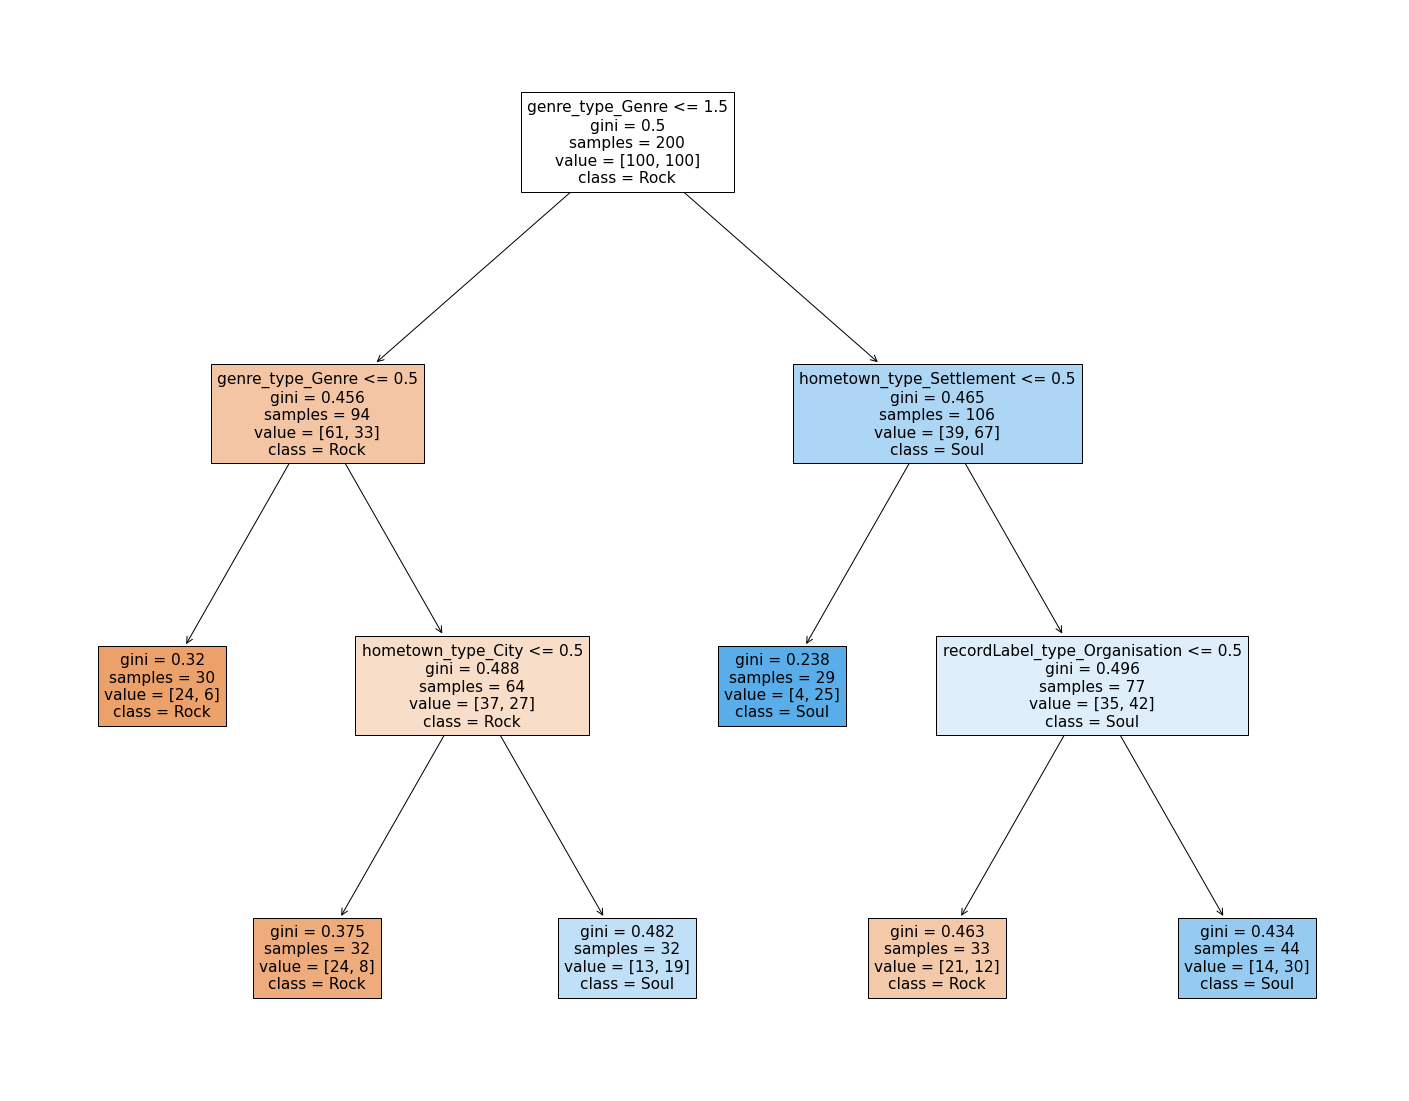

In [12]:
# build and plot a decision tree
from sklearn import tree
from matplotlib import pyplot as plt

# beautify feature names for decision tree for visualization
features=dfX.columns
features = [f.replace('Band_type_http://dbpedia.org/ontology/', '') for f in features]
features = [f.replace('Link_Out_count_http://dbpedia.org/ontology/', '') for f in features]
features = [f.replace('Link_Out_count_http://www.w3.org/1999/02/22-rdf-syntax-ns#', '') for f in features]
features = [f.replace('http://dbpedia.org/ontology/', '') for f in features]

# learn and plot tree
clf = tree.DecisionTreeClassifier(min_samples_leaf=25)
clf = clf.fit(dfX, dfY)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,
                   class_names=dfY['Genre'].unique(),
                   filled=True)

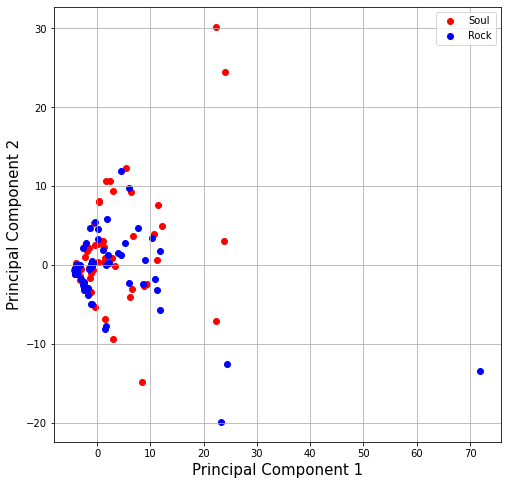

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dfX)
principalDf = pd.DataFrame(data = pca_result
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, dfY], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

targets = ['Soul','Rock']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Genre'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color)
ax.legend(targets)
ax.grid()